<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D3_ModelFitting/W1D3_Tutorial5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 1, Day 3, Tutorial 5
# Model Selection: Bias-variance trade-off

**Content creators**: Pierre-Étienne Fiquet, Anqi Wu, Alex Hyafil with help from Ella Batty

**Content reviewers**: Lina Teichmann, Patrick Mineault, Michael Waskom




---
#Tutorial Objectives

This is Tutorial 5 of a series on fitting models to data. We start with simple linear regression, using least squares optimization (Tutorial 1) and Maximum Likelihood Estimation (Tutorial 2). We will use bootstrapping to build confidence intervals around the inferred linear model parameters (Tutorial 3). We'll finish our exploration of regression models by generalizing to multiple linear regression and polynomial regression (Tutorial 4). We end by learning how to choose between these various models. We discuss the bias-variance trade-off (Tutorial 5) and Cross Validation for model selection (Tutorial 6).

In this tutorial, we will learn about the bias-variance tradeoff and see it in action using polynomial regression models.

Tutorial objectives:

* Understand difference between test and train data
* Compare train and test error for models of varying complexity
* Understand how bias-variance tradeoff relates to what model we choose

Video available at https://youtube.com/watch?v=NcUH_seBcVw


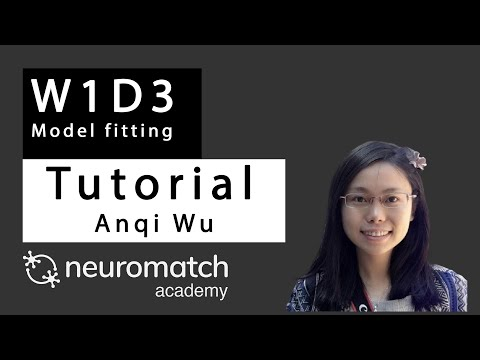

In [1]:
#@title Video 1: Bias Variance Tradeoff
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="NcUH_seBcVw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---
# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [4]:
#@title Helper functions
def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """

  return np.linalg.inv(x.T @ x) @ x.T @ y

def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0],1))

  # Loop through rest of degrees and stack columns
  for degree in range(1, order+1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order+1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hats[order] = this_theta

  return theta_hats

---
# Section 1: Train vs test data

 The data used for the fitting procedure for a given model is the **training data**. In tutorial 4, we computed MSE on the training data of our polynomial regression models and compared training MSE across models. An additional important type of data is **test data**. This is held-out data that is not used (in any way) during the fitting procedure. When fitting models, we often want to consider both the train error (the quality of prediction on the training data) and the test error (the quality of prediction on the test data) as we will see in the next section.


We will generate some noisy data for use in this tutorial using a similar process as in Tutorial 4.However, now we will also generate test data. We want to see how our model generalizes beyond the range of values see in the training phase. To accomplish this, we will generate x from a wider range of values ([-3, 3]). We then plot the train and test data together.

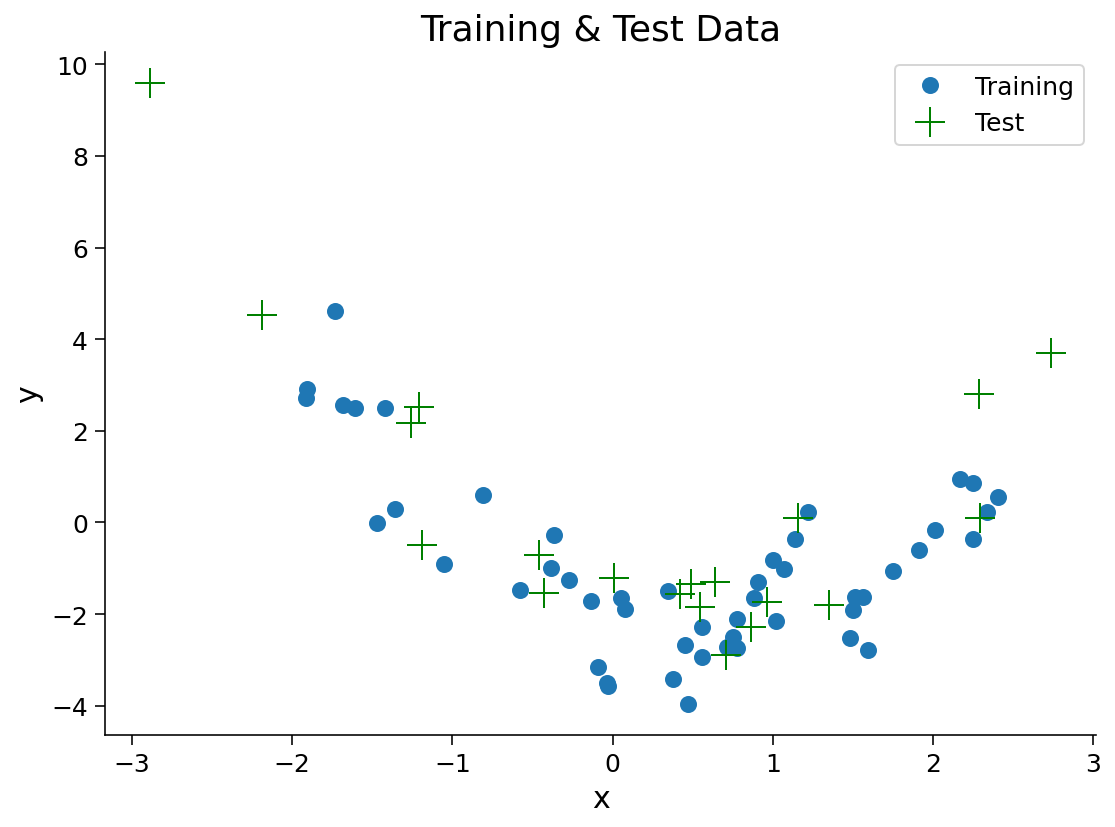

In [5]:
#@title
#@markdown Execute this cell to simulate both training and test data

### Generate training data
np.random.seed(0)
n_train_samples = 50
x_train = np.random.uniform(-2, 2.5, n_train_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples) # sample from a standard normal distribution
y_train =  x_train**2 - x_train - 2 + noise

### Generate testing data
n_test_samples = 20
x_test = np.random.uniform(-3, 3, n_test_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_test_samples) # sample from a standard normal distribution
y_test =  x_test**2 - x_test - 2 + noise

## Plot both train and test data
fig, ax = plt.subplots()
plt.title('Training & Test Data')
plt.plot(x_train, y_train, '.', markersize=15, label='Training')
plt.plot(x_test, y_test, 'g+', markersize=15, label='Test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

---
# Section 2: Bias-variance tradeoff

Finding a good model can be difficult. One of the most important concepts to keep in mind when modeling is the **bias-variance tradeoff**. 

**Bias** is the difference between the prediction of the model and the corresponding true output variables you are trying to predict. Models with high bias will not fit the training data well since the predictions are quite different from the true data. These high bias models are overly simplified - they do not have enough parameters and complexity to accurately capture the patterns in the data and are thus **underfitting**.


**Variance** refers to the variability of model predictions for a given input. Essentially, do the model predictions change a lot with changes in the exact training data used? Models with high variance are highly dependent on the exact training data used - they will not generalize well to test data. These high variance models are **overfitting** to the data.

In essence:

* High bias, low variance models have high train and test error.
* Low bias, high variance models have low train error, high test error
* Low bias, low variance models have low train and test error


As we can see from this list, we ideally want low bias and low variance models! These goals can be in conflict though - models with enough complexity to have low bias also tend to overfit and depend on the training data more. We need to decide on the correct tradeoff.

In this section, we will see the bias-variance tradeoff in action with polynomial regression models of different orders.

Graphical illustration of bias and variance.
(Source: http://scott.fortmann-roe.com/docs/BiasVariance.html)

![bias-variance](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/images/bias_variance/bullseye.png) 


We will first fit polynomial regression models of orders 0-5 on our simulated training data just as we did in Tutorial 4. 

In [6]:
#@title
#@markdown Execute this cell to estimate theta_hats
max_order = 5
theta_hats = solve_poly_reg(x_train, y_train, max_order)

### Exercise 1: Compute and compare train vs test error

We will use MSE as our error metric again. Compute MSE on training data ($x_{train},y_{train}$) and test data ($x_{test}, y_{test}$) for each polynomial regression model (orders 0-5). Since you already developed code in T4 Exercise 4 for evaluating fit polynomials, we have ported that here into the function ``evaluate_poly_reg`` for your use.

*Please think about after completing exercise before reading the following text! Do you think the order 0 model has high or low bias? High or low variance? How about the order 5 model?*

In [7]:
def evaluate_poly_reg(x, y, theta_hats, max_order):
    """ Evaluates MSE of polynomial regression models on data

    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hats (dict):  fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit

    Returns
      (ndarray): mean squared error for each order, shape (max_order)
    """

    mse = np.zeros((max_order + 1))
    for order in range(0, max_order + 1):
      X_design = make_design_matrix(x, order)
      y_hat = np.dot(X_design, theta_hats[order])
      residuals = y - y_hat
      mse[order] = np.mean(residuals ** 2)

    return mse

No handles with labels found to put in legend.


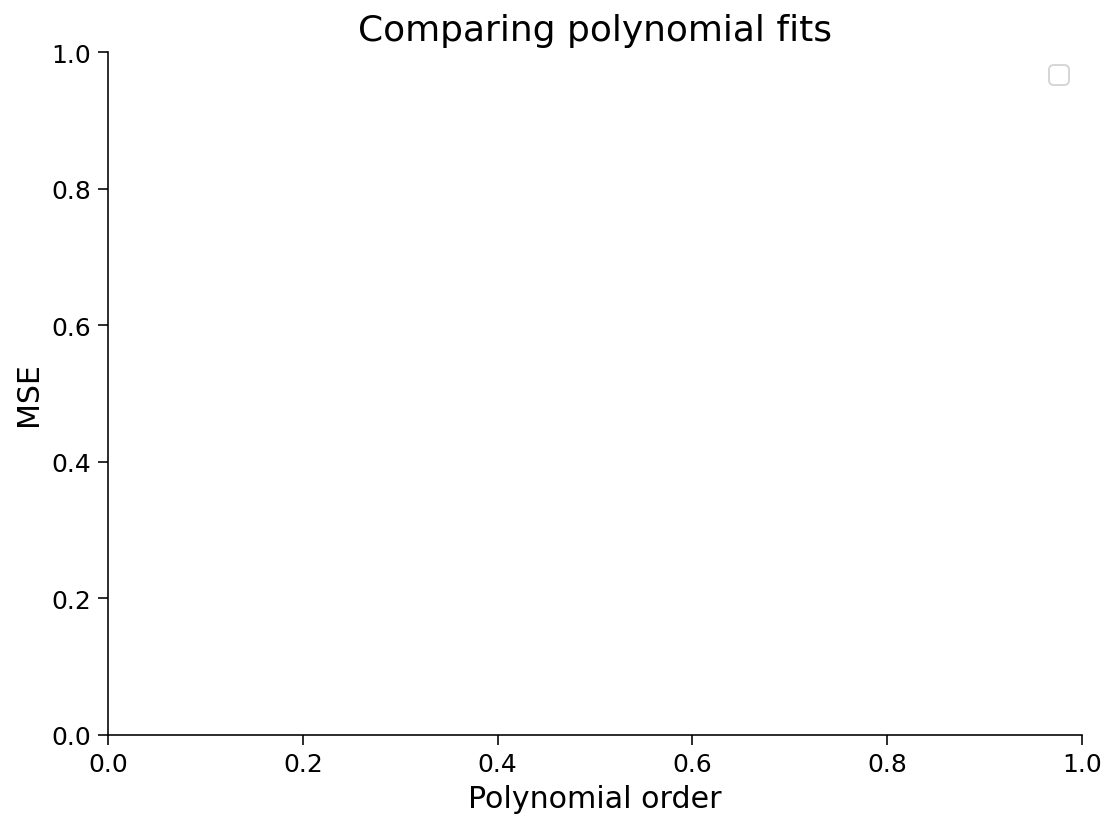

In [8]:
def compute_mse(x_train,x_test,y_train,y_test,theta_hats,max_order):
  """Compute MSE on training data and test data.

  Args:
    x_train(ndarray): training data input vector of shape (n_samples)
    x_test(ndarray): test data input vector of shape (n_samples)
    y_train(ndarray): training vector of measurements of shape (n_samples)
    y_test(ndarray): test vector of measurements of shape (n_samples)
    theta_hats(dict): fitted weights for each polynomial model (dict key is order)
    max_order (scalar): max order of polynomial fit

  Returns:
    ndarray, ndarray: MSE error on training data and test data for each order
  """

  #######################################################
  ## TODO for students: calculate mse error for both sets
  ## Hint: look back at tutorial 5 where we calculated MSE
  # Fill out function and remove
  raise NotImplementedError("Student excercise: calculate mse for train and test set")
  #######################################################

  mse_train = ...
  mse_test = ...

  return mse_train, mse_test


#Uncomment below to test your function
# mse_train, mse_test = compute_mse(x_train, x_test, y_train, y_test, theta_hats, max_order)

fig, ax = plt.subplots()
width = .35

# ax.bar(np.arange(max_order + 1) - width / 2, mse_train, width, label="train MSE")
# ax.bar(np.arange(max_order + 1) + width / 2, mse_test , width, label="test MSE")

ax.legend()
ax.set(xlabel='Polynomial order', ylabel='MSE', title ='Comparing polynomial fits');

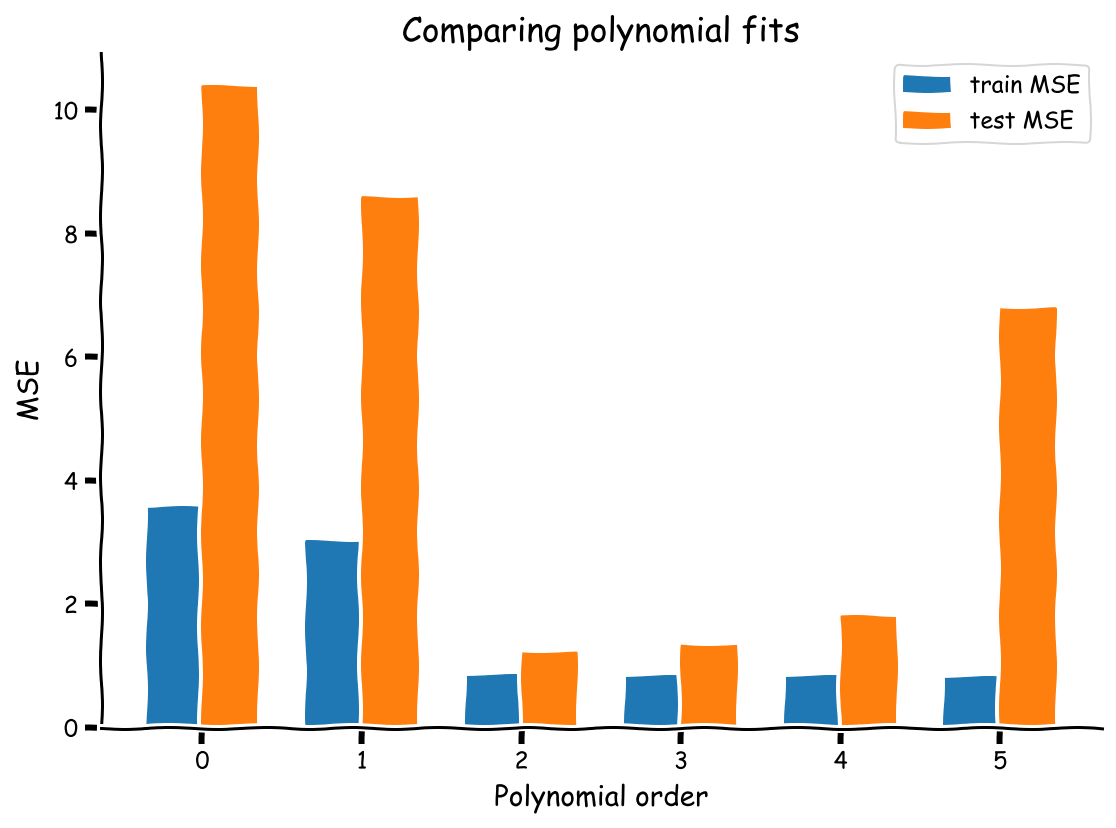

In [9]:
# to_remove solution

def compute_mse(x_train,x_test,y_train,y_test,theta_hats,max_order):
  """Compute MSE on training data and test data.

  Args:
    x_train(ndarray): training data input vector of shape (n_samples)
    x_test(ndarray): test vector of shape (n_samples)
    y_train(ndarray): training vector of measurements of shape (n_samples)
    y_test(ndarray): test vector of measurements of shape (n_samples)
    theta_hats(dict): fitted weights for each polynomial model (dict key is order)
    max_order (scalar): max order of polynomial fit

  Returns:
    ndarray, ndarray: MSE error on training data and test data for each order
  """

  mse_train = evaluate_poly_reg(x_train, y_train, theta_hats, max_order)
  mse_test = evaluate_poly_reg(x_test, y_test, theta_hats, max_order)

  return mse_train, mse_test


mse_train, mse_test = compute_mse(x_train, x_test, y_train, y_test, theta_hats, max_order)

with plt.xkcd():
  fig, ax = plt.subplots()
  width = .35

  ax.bar(np.arange(max_order + 1) - width / 2, mse_train, width, label="train MSE")
  ax.bar(np.arange(max_order + 1) + width / 2, mse_test , width, label="test MSE")

  ax.legend()
  ax.set(xlabel='Polynomial order', ylabel='MSE', title ='Comparing polynomial fits');

As we can see from the plot above, more complex models (higher order polynomials) have lower MSE for training data. The overly simplified models (orders 0 and 1) have high MSE on the training data. As we add complexity to the model, we go from high bias to low bias. 

The MSE on test data follows a different pattern. The best test MSE is for an order 2 model - this makes sense as the data was generated with an order 2 model. Both simpler models and more complex models have higher test MSE. 

So to recap:

Order 0 model: High bias, low variance

Order 5 model: Low bias, high variance

Order 2 model: Just right, low bias, low variance


---
# Summary

- Training data is the data used for fitting, test data is held-out data.
- We need to strike the right balance between bias and variance. Ideally we want to find a model with optimal model complexity that has both low bias and low variance
 - Too complex models have low bias and high variance.
 - Too simple models have high bias and low variance.

**Note**
 - Bias and variance are very important concepts in modern machine learning, but it has recently been observed that they do not necessaruly trade off (see for example the phenomenon and theory of "double descent")

**Further readings:**
- [The elements of statistical learning](https://web.stanford.edu/~hastie/ElemStatLearn/) by Hastie, Tibshirani and Friedman

---
# Appendix



## Bonus Exercise

Prove the bias-variance decomposition for MSE

$$
\mathrm{E}_{x}\left[(y-\hat{y}(x ; \theta))^{2}\right]=\left(\operatorname{Bias}_{x}[\hat{y}(x ; \theta)]\right)^{2}+\operatorname{Var}_{x}[\hat{y}(x ; \theta)]+\sigma^{2}
$$where
$$\operatorname{Bias}_{x}[\hat{y}(x ; \theta)]=\mathrm{E}_{x}[\hat{y}(x ; \theta)]-y
$$and
$$\operatorname{Var}_{x}[\hat{y}(x ; \theta)]=\mathrm{E}_{x}\left[\hat{y}(x ; \theta)^{2}\right]-\mathrm{E}_{x}[\hat{y}(x ; \theta)]^{2}
$$

Hint: use $$\operatorname{Var}[X]=\mathrm{E}\left[X^{2}\right]-(\mathrm{E}[X])^{2}$$